## Retrieve and filter papers from DBLP
The purpose of this notebook is to use DBLP to contain a list of refereed papers from the venues included on the CSmetrics website. Also included are some comparisons of several of different filtering methods.

In [1]:
import os, json, requests, csv
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

from paper_filtering import filter_by_header
from paper_filtering import filter_by_page_number_keep_missing
from paper_filtering import filter_by_page_number_remove_missing
from paper_filtering import filter_by_header_and_page_number_keep_missing
from paper_filtering import filter_by_header_and_page_number_remove_missing
from paper_filtering import filter_journals
from paper_filtering import apply_filter_to_papers

In [2]:
# filename templates for the data
dblp_raw_filename = lambda name,year: os.path.join( "DBLP_raw_data" , 
                                              "{}_{}_raw_dblp_papers.json".format(name,year) )
    
# filepath to the PublicationCleaningNote.csv file (to be read)
pub_cleaning_note_filename = os.path.join(os.pardir,"docs","PublicationCleaningNote.csv")

# filepath to the file to record the counts of each different filtering method in the test
pub_filtering_test_counts_filename = "PublicationFilteringTestCounts.csv"

# filepath to plot comparing different filtering methods
filtering_count_comparison_fiename = os.path.join(os.pardir, "docs","filtering_count_comparison.png")

# filepath to the file containing venue names and their categories (conf or journal)
venue_category_filename = os.path.join(os.pardir,"old_data","venue_category.csv")

# filepath to the file containing a list of venues to be scraped using different keys
venues_with_different_keys_filename = "venues_with_different_dblp_keys.csv"

# filepath to the file containing a list of venues to be scraped using a different base url
venues_with_different_baseurls = "venues_with_different_dblp_baseurls.csv"

# filepath to the file containing a list of journals to be scraped using a different method
journals_to_be_scraped_using_alternative_method = "journals_to_use_alternative_scraping_method.csv"

# filepath to the file containing the publication and filtering count for the data set
pub_filtering_counts_filename = "PublicationFilteringCounts.csv"

#### Function for scraping papers for a given conference and year

In [3]:
# Simple function to check whether a beautiful soup element has a given attribute
def has_attribute(element, attr):
    try:
        element[attr]
        return True
    except:
        return False

def get_papers_from_page(url, year, params = {}):
    # DBLP url template for the website scraped

    content = requests.get(url).text

    soup = BeautifulSoup(content)
    
    parameters = {
        "classname": "entry inproceedings"
    }
    
    for param, value in params.items():
        parameters[param] = value

    papers = {"noheader":[]}

    header = None

    for element in soup.find(id="main").children:

        # Get the name of the upcoming section of the proceedings
        if element.name=="header":

            # based on observations this is the correct level of heading
            h2 = element.find("h2")
            if h2:
                header = h2.text
                if header not in papers:
                    papers[header] = []

            continue

        # Get papers if the element is a publication list
        if element.name=="ul" and has_attribute(element, "class") and "publ-list" in element["class"] :

            # Observed that all paper list items have the class (that arent't the proceedings)
            #  have the class "entry inproceedings" as opposed to "entry editor"
            for paperli in element.find_all("li", attrs={parameters["classname"]}):
                data = paperli.find("article", attrs={"class": "data"})

                title = data.find("span", attrs={"class": "title"}).text

                # do not include front matter
                if "front matter" in title.lower():
                    continue 

                # do not include key notes
                if "keynote" in title.lower():
                    continue 

                pagination = data.find("span", attrs={"itemprop": "pagination"})
                if pagination is not None:
                    pagination = pagination.text

                year = year

                authors = []
                for authorspan in data.find_all("span", attrs={"itemprop": "author"}):
                    authors.append(authorspan.find("span", attrs={"itemprop": "name"}).text)

                paper = {"title": title,
                         "pagination": pagination,
                        "year": year,
                        "authors": authors}

                # if a section header has not been identified for this list of papers
                if header == None: 
                    papers["noheader"].append(paper)

                else:
                    papers[header].append(paper)

    return papers

            
            
def get_papers_from_dblp(name, year, force=False, save=True, groupname=None):
    
    # file name for saved data
    filename = dblp_raw_filename(name,year)

    # check whether the file already exists
    exists = os.path.exists(filename)
    
    # scrape the data if it doesnt exist or instructed to force/overwrite file
    if force or not exists:
        
        if groupname == None: groupname = name
        
        url = "https://dblp.org/db/conf/{0}/{1}{2}.html".format(groupname, name,year)
        
        papers = get_papers_from_page(url,year)

        
        try_next_volume = True
        next_volume = 1

        while try_next_volume:

            url = "https://dblp.org/db/conf/{0}/{1}{2}-{3}.html".format(groupname,name,year,next_volume)

            papers_volume = get_papers_from_page(url, year)

            for header, paperlist in papers_volume.items():
                if header in papers:
                    papers[header].extend(paperlist)
                else:
                    papers[header] = paperlist

            # if found no papers from this volume, and tried up to volume 2
            if sum([len(v) for v in papers_volume.values()]) == 0 and next_volume >= 2:
                try_next_volume = False

            # otherwise look for a next volume
            else:
                next_volume += 1
                    
            
        if save:
            with open(filename, "w") as fh:
                json.dump(papers, fh)

    # otherwise load the existing file
    else:
        with open(filename, "r") as fh:
            papers = json.load(fh)


    return papers

In [4]:
def get_journal_papers_from_dblp_old(name,year, force=False):
    
    
    # file name for saved data
    filename = dblp_raw_filename(name,year)

    # check whether the file already exists
    exists = os.path.exists(filename)
    
    # scrape the data if it doesnt exist or instructed to force/overwrite file
    if force or not exists:
        
        # API Base URL (https://dblp.uni-trier.de/faq/13501473)
        url = "https://dblp.org/search/publ/api"

        params = lambda venue, year, index:{
            "q": "venue:{}:year:{}:".format(venue, year), # query
            "h": 1000, # max number of hits (API capped at 1000)
            "f": index, #
            "format": "json"
        }

        papers = list()

        continue_searching = True
        index = 0

        while continue_searching:
            resp = requests.get(url=url, params=params(name, year, index))
            data = resp.json()["result"]["hits"]
            if int(data["@sent"]) == 0:
                continue_searching = False
                continue
            papers.extend( [paper["info"] for paper in data["hit"]] )
            index += 1000

        with open(filename, "w") as fh:
            json.dump(papers, fh)
    
    # otherwise load the existing file
    else:
        with open(filename(name_for_file, year), "r") as fh:
            papers = json.load(fh)

    return papers


In [5]:
def get_links_to_journal_volumes(name,year, alternative_method = False):
    # DBLP url template for the journal homesite
    url = "https://dblp.org/db/journals/{0}/".format(name)

    content = requests.get(url).text
    soup = BeautifulSoup(content)

    output = []
    
    for element in soup.find(id="main").children:
        if element.name=="ul":
            for listitem in element.children:
                if listitem.find("a") != -1:
                    
                    if alternative_method:
                        if str(year) in listitem.contents[0]:
                            for link in listitem.find_all('a'):
                                output.append({"url": link["href"], "text": listitem.contents[0] + link.text})

                    link = listitem.find("a")
                    if link is None:
                        continue
                    if str(year) in link.text:
                        output.append({"url": link["href"], "text": link.text})
                        
                        

    return output


def get_journal_papers_from_dblp(name, year, force=False, save=True, links=None, alt=False):
    
    # file name for saved data
    filename = dblp_raw_filename(name,year)

    # check whether the file already exists
    exists = os.path.exists(filename)
    
    # scrape the data if it doesnt exist or instructed to force/overwrite file
    if force or not exists:

        papers = {}
        
        if links == None:
            links = get_links_to_journal_volumes(name,year, alternative_method=alt)
        
        for volume in links:
            
            url = volume["url"]

            content = requests.get(url).text
            soup = BeautifulSoup(content)

            header = volume["text"]

            for element in soup.find(id="main").children:

                # Get the name of the upcoming section of the proceedings
                if element.name=="header":

                    # based on observations this is the correct level of heading
                    h2 = element.find("h2")
                    if h2:
                        header = h2.text
                        if header not in papers and str(year) in header:
                            papers[header] = []

                    continue

                # Get papers if the element is a publication list
                if element.name=="ul" and "publ-list" in element["class"] :
                    
                    # if header doesnt indicate it is in the desired year, continue
                    if str(year) not in header:
                        continue
                    
                    # Observed that all paper list items have the class (that arent't the proceedings)
                    #  have the class "entry inproceedings" as opposed to "entry editor"
                    for paperli in element.find_all("li", attrs={"entry article"}):
                        data = paperli.find("article", attrs={"class": "data"})

                        title = data.find("span", attrs={"class": "title"}).text

                        # do not include front matter
                        if "front matter" in title.lower():
                            continue 

                        # do not include key notes
                        if "keynote" in title.lower():
                            continue 

                        pagination = data.find("span", attrs={"itemprop": "pagination"})
                        if pagination is not None:
                            pagination = pagination.text

                        year = year

                        authors = []
                        for authorspan in data.find_all("span", attrs={"itemprop": "author"}):
                            authors.append(authorspan.find("span", attrs={"itemprop": "name"}).text)

                        paper = {"title": title,
                                 "pagination": pagination,
                                "year": year,
                                "authors": authors}

                        papers[header].append(paper)


        if save:
            with open(filename, "w") as fh:
                json.dump(papers, fh)

    # otherwise load the existing file
    else:
        with open(filename, "r") as fh:
            papers = json.load(fh)


    return papers

## Filtering method comparison
#### Get data to test with
We test the filtering methods we using the random sample of (conference,year) tuples from PublicationCleaningNote.csv. The code below is used to retrieve and save the data from DBLP for each of the samples.

In [6]:
with open(pub_cleaning_note_filename, "r") as fh:
    
    reader = csv.reader(fh, delimiter=",")
    
    # skip header row
    next(reader)

    for row in reader:
        
        # skip rows without the conference name and year
        try:
            name, year = row[0].split()
            name = name.lower()        
        except:
            continue
        
        # Scrape and save the papers for the test file if not already saved
        get_papers_from_dblp(name,year, force=False)

#### Define the different filtering methods for comparison

Five different filtering methods are defined in `filtering_papers.py`
- ```filter_by_header``` 'Header': this method uses information contained in the header of the section the paper was scraped from. Specifically, if the section header for a paper contains particular keywords (for example "demo" or "poster", see code for full list) then that paper will be excluded. Not all venues are divided into sections on DBLP and in cases where there are papers without section headers, all such papers are included.


- ```filter_by_page_number_keep_missing``` 'Page Num (k)':  this method uses information about the pagination for the paper as scraped from DBPL with the rest of the paper information. The pagination which is pulled from the webpage HTML and stored as a string is parsed into a start and end page number. Using these numbers, the length of the papers is determined and papers are included if they meet a minimum page length. The *keep_missing* and (k) in the function name and legend label for this filter refer to the method used for dealing with papers for which pagination information could not be validly formatted into a start and end page. In this instance, papers without valid pagination are included (i.e. are not removed by the filter).


- ```filter_by_page_number_remove_missing``` 'Page Num (r)': this method is the same as ```filter_by_page_number_keep_missing``` with the exception that papers for which pagination information could not be validly formatted are not included (i.e. are removed by the filter).


- ```filter_by_header_and_page_number_keep_missing``` 'Header + Page Num (k)': This method first applies the ```filter_by_header``` method described above, and then applies the ```filter_by_page_number_keep_missing``` method to the remaining papers. This means that the resulting papers are the intersection of the papers that pass each of these filtering methods.


- ```filter_by_header_and_page_number_remove_missing``` 'Header + Page Num (r)': Similarly, this method first applies the ```filter_by_header``` method described above, and then applies the ```filter_by_page_number_remove_missing``` method to the remaining papers. Again, this means that the resulting papers are the intersection of the papers that pass each of these filtering methods.

#### Compute paper counts for the different filter methods on the test data

In [7]:
filters = [
    (filter_by_header, "Header"),
    (filter_by_page_number_keep_missing, "Page Num (k)"),
    (filter_by_page_number_remove_missing, "Page Num (r)"),
    (filter_by_header_and_page_number_keep_missing, "Header + Page Num (k)"),
    (filter_by_header_and_page_number_remove_missing, "Header + Page Num (r)")
]

with open(pub_cleaning_note_filename, "r") as fh:
    
    reader = csv.reader(fh, delimiter=",")
    
    # skip header row
    next(reader)
    
    # headers for output csv file
    outfile_header =  ["name", "year", "Original count", "Editor count", 
                       *[filter_heading for filter_f, filter_heading in filters],
                      "Original clearning notes"]
    
    with open(pub_filtering_test_counts_filename, "w") as fh_out:
        writer = csv.writer(fh_out, delimiter=",")
        writer.writerow(outfile_header)

    # iterate rows of the publication cleaning note file
    for row in reader:

        # skip rows without the conference name and year
        try:
            name, year = row[0].split()
            name = name.lower()        
        except:
            continue

        # load the papers for the test file
        papers = get_papers_from_dblp(name,year, force=False)
        
        original_count = row[1]
        editor_count = row[2]
        original_note = row[3]
        
        row = [name, year,original_count, editor_count,
               *[len(apply_filter_to_papers(filter_f, papers, name, year)[0])  for filter_f, filter_heading in filters],
               original_note]
        
        with open(pub_filtering_test_counts_filename, "a") as fh_out:
            writer = csv.writer(fh_out, delimiter=",")
            writer.writerow(row)

#### Compute and plot differences in paper counts

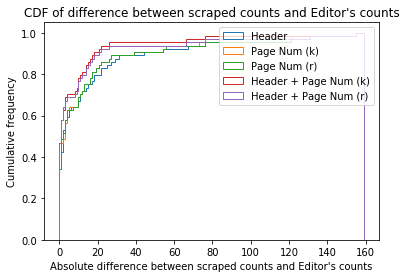

In [8]:
scraping_counts = pd.read_csv(pub_filtering_test_counts_filename)

# row 13 does not compute the figures correctly
scraping_counts = scraping_counts.drop(13)

# get number from strings containing comments
scraping_counts["Editor count"] = scraping_counts["Editor count"].apply(lambda x: int(x.split()[0]))

# plot cdf
plt.title("CDF of difference between scraped counts and Editor's counts")
plt.xlabel("Absolute difference between scraped counts and Editor's counts")
plt.ylabel("Cumulative frequency")
for filter_f, filter_heading in filters:
    series = scraping_counts["Editor count"] - scraping_counts[filter_heading]
    series = abs(series)
    plt.hist(series, cumulative=True, density=True, histtype="step", bins=range(160), label=filter_heading)
plt.legend()
plt.savefig(filtering_count_comparison_fiename)
plt.show()

#### View the scraping counts for the different methods for each test observation

In [9]:
scraping_counts

,name,year,Original count,Editor count,Header,Page Num (k),Page Num (r),Header + Page Num (k),Header + Page Num (r),Original clearning notes
0,acl,2007,131,131,131,204,0,131,0,NaN
1,ancs,2014,19,19,34,19,19,19,19,NaN
2,arith,2013,27,23,26,24,24,24,24,Found 2 additional keynote address and 2 short...
3,asap,2010,32,32,50,51,51,50,50,NaN
4,avss,2013,67,67,67,80,80,67,67,NaN
5,bibe,2012,133,134,133,131,131,131,131,Must have manually removed a paper that I shou...
6,cav,2008,47,33,47,50,50,47,47,"There are 14 tool papers. I included these, sh..."
7,cav,2014,57,46,57,57,57,57,57,"Their short papers were still 7+ pages, which ..."
8,ccgrid,2014,66,54,72,108,108,63,63,I have removed 12 papers. A 'competition' cate...
9,ccgrid,2010,65,51,80,107,107,65,65,Found 14 short papers under typical section he...


## Get raw paper files for all venues

In [10]:
with open(pub_filtering_counts_filename, "w") as fh:
    writer = csv.writer(fh, delimiter=",")
    header = ["name", "year", "total publications", "filtered publications"]
    writer.writerow(header)

with open(venue_category_filename, "r") as fh:
    
    reader = csv.reader(fh, delimiter=",")
    
    # skip header row
    next(reader)
    
    for row in reader:
        
        venue_type = row[4]   
        name = row[0]
    
        # set which paper getting / filtering functions to use
        if venue_type == "conference":
            get_papers_f = get_papers_from_dblp
            filter_f = filter_by_header_and_page_number_keep_missing
        else: # is journal
            get_papers_f = get_journal_papers_from_dblp
            filter_f = filter_journals

        # 2007-2019
        for year in range(2007,2020):

            # Scrape and save the papers if not already saved
            papers = get_papers_f(name,year)
                
            included, excluded = apply_filter_to_papers(filter_f, papers, name, year)
            totalpubs = len(included) + len(excluded)
            filteredpubs = len(included)
            with open(pub_filtering_counts_filename, "a") as fh:
                writer = csv.writer(fh, delimiter=",")
                outrow = [name, year, totalpubs, filteredpubs]
                writer.writerow(outrow)
            #print(outrow)

In [11]:
data = pd.read_csv(pub_filtering_counts_filename)

In [12]:
data["iszero"] = data["filtered publications"] ==0
data.groupby("name").sum().sort_values("iszero", ascending=False)[:20]

,year,total publications,filtered publications,iszero
name,,,,
jair,26169,0,0,13.0
ai,26169,0,0,13.0
ml,26169,0,0,13.0
amai,26169,0,0,13.0
3dim,26169,53,49,12.0
ismb,26169,118,118,11.0
wcci,26169,31,31,11.0
mobisec,26169,66,63,9.0
civr,26169,300,259,9.0


In [13]:
data[data["name"]=="ismb"]

,name,year,total publications,filtered publications,iszero
1794,ismb,2007,68,68,False
1795,ismb,2008,50,50,False
1796,ismb,2009,0,0,True
1797,ismb,2010,0,0,True
1798,ismb,2011,0,0,True
1799,ismb,2012,0,0,True
1800,ismb,2013,0,0,True
1801,ismb,2014,0,0,True
1802,ismb,2015,0,0,True
1803,ismb,2016,0,0,True


### Extra scraping for missed papers
Papers for some venues were not accurately retrieved in the scraping process for a number of different reasons. The following few code blocks were used to address these shortfalls after the problems were identified through checking venues with many years of zero paper counts.

#### Venues with different keys used in our database compared to the key used by DBLP
A list of venues where the keys contained in `/app/data/venue_list.csv` are not the same as the key used by DBLP to represent the same venue is contained in `/data/venues_with_different_dblp_keys.csv`. The following code block retrieves the papers from DBLP (by scraping the html) using the DBLP key and saves the file using the relevant key listed in `venue_list.csv` in the name of file that the papers are saved in.

In [14]:
run_different_key_scraping = False

if run_different_key_scraping:
    
    with open(venues_with_different_keys_filename, "r") as fh:
        reader = csv.reader(fh, delimiter = ",")

        next(reader)

        for key, dblp_key, venue_type, period_start, period_end in reader:

            get_papers_function = get_journal_papers_from_dblp if venue_type == "journal" else get_papers_from_dblp

            for year in range(int(period_start), int(period_end) + 1):

                papers = get_papers_function(dblp_key, year, force=True, save=False)

                filename = dblp_raw_filename(key, year)

                with open(filename,"w") as papers_fh:
                    json.dump(papers, papers_fh)

#### Venues that did did not fit the general DBLP url template
A list of conferences* where the url for the DBLP data did not fit the simple format matched by most conferences, that is https://dblp.org/db/conf/{key}/{key}{year}.html, can be found at `/data/venues_with_different_dblp_baseurls.csv`. Generally this occurs where DBLP has group multiple conferences/workshops together under one group key and then use the conference key to specify after that, i.e. https://dblp.org/db/conf/{groupkey}/{conferencekey}{year}.html. The following code block retrieves the papers from DBLP using the correct specified url base and then saves them using the given key for each year in the year period given.


_*This list only contains conferences because the method used to scrape the journals makes this problem unique to the conferences. More specifically, the method for journals does not use a set template for each (venue, year) tuple because the journals are stored by volume number rather than year._

In [15]:
run_custom_url_scraping = False

if run_custom_url_scraping:
    
    with open(venues_with_different_baseurls, "r") as fh:
        reader = csv.reader(fh, delimiter = ",")

        next(reader)

        for key, urlbase, period_start, period_end in reader:

            for year in range(int(period_start), int(period_end) + 1):

                url = urlbase.format(year)

                papers = get_papers_from_page(url, year)

                filename = dblp_raw_filename(key, year)

                with open(filename,"w") as papers_fh:
                    json.dump(papers, papers_fh)

#### Journals that needed to be retrieved through an alternative scraping method
A list of journals where that needed to be scraped using an alternative method is at `/data/journals_to_use_alternative_scraping_method.csv`. The webpages for these journals listed the volumes in a different way and therefore were not picked up by the standard scraping method used for most journals. The code block below retrieves and saves the papers for these journals for each of the respective journals in each year between (inclusive) the period defined.

In [16]:
run_alt_journal_scraping = False

if run_alt_journal_scraping:
    
    with open(journals_to_be_scraped_using_alternative_method, "r") as fh:
        reader = csv.reader(fh, delimiter = ",")

        next(reader)

        for key, period_start, period_end in reader:

            for year in range(int(period_start), int(period_end) + 1):

                url = urlbase.format(year)

                papers = get_journal_papers_from_dblp(url, year, force=True,save=False,alt=True)

                filename = dblp_raw_filename(key, year)

                with open(filename,"w") as papers_fh:
                    json.dump(papers, papers_fh)

## Explore the paper counts for the venues

In [17]:
data["filterediszero"] = data["filtered publications"] ==0
data_agg = data.groupby("name").sum()
data_agg[data_agg["iszero"]!=data_agg["filterediszero"]]

,year,total publications,filtered publications,iszero,filterediszero
name,,,,,


In [18]:
data_agg["removed"] = data_agg["total publications"] - data_agg["filtered publications"]
data_agg["removed pc"] = data_agg["removed"] / data_agg["total publications"]

In [19]:
data_agg.sort_values("removed pc", ascending=False)

,year,total publications,filtered publications,iszero,filterediszero,removed,removed pc
name,,,,,,,
isscc,26169,2919,259,1.0,1.0,2660,0.911271
vr,26169,1304,374,1.0,1.0,930,0.713190
sensys,26169,893,287,1.0,1.0,606,0.678611
aamas,26169,3680,1569,3.0,3.0,2111,0.573641
cacm,26169,3804,1687,0.0,0.0,2117,0.556519
ipsn,26169,815,372,0.0,0.0,443,0.543558
sigcse,26169,3012,1412,0.0,0.0,1600,0.531208
jcdl,26169,1124,528,1.0,1.0,596,0.530249
mobisys,26169,778,380,0.0,0.0,398,0.511568


In [20]:
data.sum()

name                     3dim3dim3dim3dim3dim3dim3dim3dim3dim3dim3dim3d...
year                                                               7955376
total publications                                                  386817
filtered publications                                               337010
iszero                                                                 482
filterediszero                                                         482
dtype: object